In [3]:
import numpy as np
from sklearn.linear_model import lasso_path
import matplotlib.pyplot as plt

## Functions to compute TPP and FDP along the Lasso path

In [5]:
def TPP(beta_true, beta_pred):
    """
    Computes True Positive Proportion between true and learned feature coefficients.
    
    beta_true, beta_pred : np.array of feature coefficients.
    """
    n1 = (beta_pred != 0)
    n2 = (beta_true != 0)
    
    return (n1 * n2).sum()/max(n2.sum(), 1)

def FDP(beta_true, beta_pred):
    """
    Computes False Discovery Proportion between true and learned feature coefficients.
    
    beta_true, beta_pred : np.array of feature coefficients.
    """
    n1 = (beta_pred != 0)
    n2 = (beta_true == 0)
    
    return (n1 * n2).sum()/max(n1.sum(), 1)

def TPP_FDP_path(p = 1000, n = None, delta = 0.3, epsilon = 0.2, sigma = 1, signal_intensity = 4, n_alphas = 1000, alpha_min = -5, alpha_max = 2):
    """
    Simulates a dataset and returns the FDP and TPP for each alpha in the Lasso path.
    
    p : Number of features.
    
    n : Number of observations.
    
    delta : ratio of observations n over number of features p (delta = n/p). Used if n is not given and ignored otherwise.
    
    epsilon: ratio of non-null features.
    
    sigma: standard deviation of the observation noise.
    
    signal_intensity: value of non-null feature coefficients.
    
    n_alphas = number of alphas to be tested in the Lasso path.   
    
    alpha_min, alpha_max : range of values alpha should take in log scale.
    
    Returns TPP path and FDP path.
    """
    # number of observations
    if n is None:
        n = int(p * delta)
    
    # simulate dataset X
    X = np.random.randn(n, p) / np.sqrt(n)
    
    # define true coefficients
    nonnull_coefs = int(epsilon * p)
    beta = np.hstack([np.zeros(p - nonnull_coefs), signal_intensity * np.ones(nonnull_coefs)])
    
    # simulate noise
    z = np.random.rand(n) * sigma
    
    # compute target variable
    Y = X.dot(beta) + z
    
    # compute Lasso path
    alphas, active, coef_path_lars = lasso_path(X, Y, alphas = np.logspace(alpha_min, alpha_max, n_alphas))
    
    # evaluate TPP and FDP for each alpha
    tpp_path = []
    fdp_path = []
    for coefs in active.T:
        tpp_path.append(TPP(beta, coefs))
        fdp_path.append(FDP(beta, coefs))
        
    return tpp_path, fdp_path
    
def plot_path(tpp_path, fdp_path):
    """
    Plots TPP path against FDP path.
    """
    plt.scatter(tpp_path, fdp_path, s = 5, label = 'Lasso Path')

    plt.xlabel('TPP')
    plt.ylabel('FDP')

    plt.legend()
    fig = plt.gcf()
    fig.set_size_inches(15, 10)
  
    


## Functions to compute $q^*$

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.datasets import make_classification
from itertools import cycle
from sklearn import preprocessing
from sklearn import linear_model
import matplotlib.gridspec as gridspec
from scipy.stats import norm
import scipy.optimize
from math import *
from matplotlib import rc
# python translated function from the matlab one downloaded from :
# https://github.com/wjsu/fdrlasso/blob/master/fdrlasso.m
# Copyright @ Weijie Su, Malgorzata Bogdan, and Emmanuel Candes, 2015

def fdrlasso(tpp, delta, epsi):
    """
    This function computes q*(tpp, delta, epsi) for a given value tpp. 
    """ 
    if tpp > powermax(delta, epsi):
        return

    if tpp == 0:
        q = 0
        return

    # make stepsize smaller for higher accuracy
    stepsize = 0.1
    tmax = max(10, np.sqrt(delta/epsi/tpp) + 1)
    tmin = tmax - stepsize

    while tmin > 0:
        if lsandwich(tmin, tpp, delta, epsi) < rsandwich(tmin, tpp):
            break
        tmax = tmin
        tmin = tmax - stepsize

    if tmin <= 0:
        stepsize = stepsize/100;
        tmax = max(10, sqrt(delta/epsi/tpp) + 1);
        tmin = tmax - stepsize;
        while tmin > 0:
            if lsandwich(tmin, tpp, delta, epsi) < rsandwich(tmin, tpp):
                break
            tmax = tmin
            tmin = tmax - stepsize

    diff = tmax - tmin
    while diff > 1e-6:
        tmid = 0.5*tmax + 0.5*tmin;
        if lsandwich(tmid, tpp, delta, epsi) > rsandwich(tmid, tpp):
            tmax = tmid
        else:    
            tmin = tmid
        diff = tmax - tmin

    t = (tmax + tmin)/2
    
    q = 2*(1-epsi)*norm.cdf(-t)/(2*(1-epsi)*norm.cdf(-t) + epsi*tpp)
    
    return q

def lsandwich(t, tpp, delta, epsi):
    Lnume = (1-epsi)*(2*(1+t**2)*norm.cdf(-t) - 2*t*norm.pdf(t)) + epsi*(1+t**2) - delta;
    Ldeno = epsi*((1+t**2)*(1-2*norm.cdf(-t)) + 2*t*norm.pdf(t));
    L = Lnume/Ldeno;
    return L

def rsandwich(t, tpp):
    R = (1 - tpp)/(1 - 2*norm.cdf(-t));
    return R

def powermax(delta, epsilon):
    if delta >= 1:
        power = 1
        return power
    epsilon_star = epsilonDT(delta);
    if epsilon <= epsilon_star:
        power = 1
        return power
    
    power = (epsilon - epsilon_star)*(delta - epsilon_star)/epsilon/(1 - epsilon_star) + epsilon_star/epsilon
    
    return power


def epsilonDT(delta):
    minus_f = lambda x : -(1+2/delta*x*norm.pdf(x) - 2/delta*(1+x**2)*norm.cdf(-x))/(1+x**2-2*(1+x**2)*norm.cdf(-x)+2*x*norm.pdf(x))*delta;
    alpha_phase = scipy.optimize.fmin(func=minus_f, x0 = 1e-16, disp=False);    
    epsi = -minus_f(alpha_phase)
    return epsi

def fdrlasso_py(delta, epsi, x_min = 1e-4, x_max = 0.99):
    """Computes q*(x, delta, epsi) for all x between x_min and x_max. Useful for plotting."""
    n = 100
    x = np.linspace(x_min, x_max, n)
    y = []
    for x_i in x:
        y.append(fdrlasso(x_i, delta, epsi))
    y = np.array(y)
    return x, y

def fdrlasso_py2(x_space,delta,epsi):
    res = []
    for x in x_space:
        res.append(fdrlasso(x, delta, epsi))
    res = np.nan_to_num(np.array(res, dtype=np.float))
    return res

## Reproducing Figure 4 of the paper

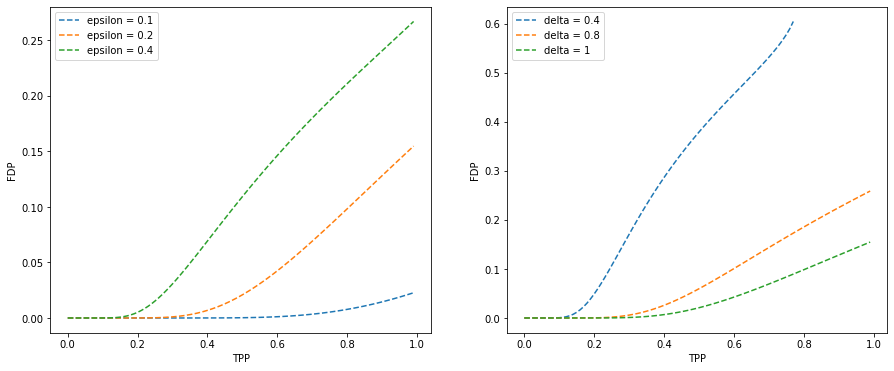

In [8]:
plt.subplot(1, 2, 1)

delta = 1
epsilons = [0.1, 0.2 ,0.4]

for epsilon in epsilons:
    x, y = fdrlasso_py(delta=delta, epsi=epsilon)
    plt.plot(x, y,'--', label = 'epsilon = ' + str(epsilon))

plt.xlabel('TPP')
plt.ylabel('FDP')
plt.legend(loc=0) 

plt.subplot(1, 2, 2)
epsilon = 0.2
deltas = [0.4, 0.8, 1]

for delta in deltas:
    x, y = fdrlasso_py(delta=delta, epsi=epsilon)
    plt.plot(x, y,'--', label = 'delta = ' + str(delta))

plt.xlabel('TPP')
plt.ylabel('FDP')
plt.legend(loc=0) 


fig = plt.gcf()
fig.set_size_inches(15,6)

## Reproducing Figure 1 of the paper

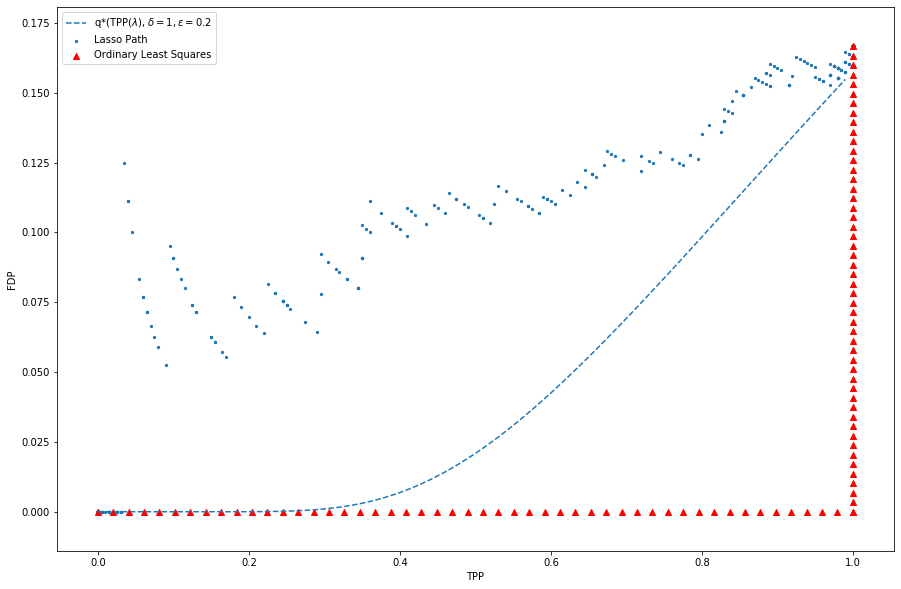

In [19]:
delta = 1
epsilon = 0.2
tpp_path, fdp_path = TPP_FDP_path(p = 1000,delta = delta, epsilon = epsilon, sigma = 0, n_alphas = 2000)
x, y = fdrlasso_py(delta=delta, epsi=epsilon)
plot_path(tpp_path, fdp_path)

plt.scatter(np.linspace(0, 1, 50), np.zeros(50), marker = '^', color = 'red', label = 'Ordinary Least Squares')
plt.scatter(np.ones(50), np.linspace(0, max(fdp_path), 50), marker = '^', color = 'red')

plt.plot(x, y,'--', label = r"q*(TPP($\lambda$), $\delta = 1, \epsilon = 0.2$)")

plt.legend()

## Figure 1 of our report

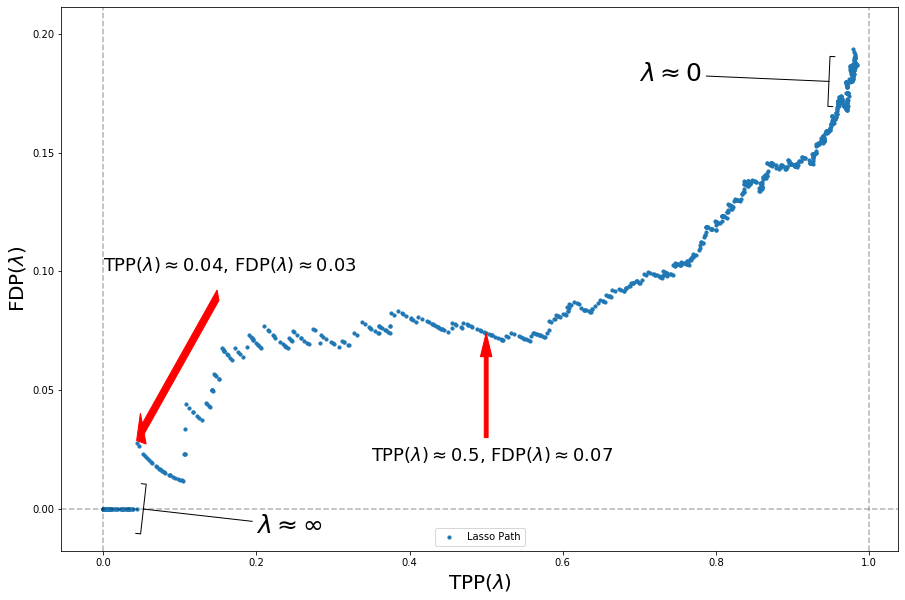

In [0]:
plt.scatter(tpp_path, fdp_path, s = 10, label = 'Lasso Path')
plt.xlabel('TPP($\lambda$)', size = 20)
plt.ylabel('FDP($\lambda$)', size = 20)
plt.axhline(y=0, color='k', linestyle = '--', alpha = 0.3)
plt.axvline(x=0, color='k', linestyle = '--', alpha = 0.3)
plt.axvline(x=1, color='k', linestyle = '--', alpha = 0.3)

plt.annotate(s = r"$\lambda \approx \infty$", xy = (0.05,0), xytext = (0.2, -0.01), arrowprops = {'arrowstyle':'-['}, size = 25)
plt.annotate(s = r"$\lambda \approx 0$", xy = (0.95, 0.18), xytext = (0.7,0.18), arrowprops = {'arrowstyle':'-['}, size = 25)

tpp_path = np.array(tpp_path)
index = np.where(tpp_path >= 0.5)[0][0]

text = r"TPP($\lambda$)$\approx$" + str(np.round(tpp_path[index], decimals = 2)) + r", FDP($\lambda$)$\approx$" + str(np.round(fdp_path[index], decimals = 2))
textx = 0.35
texty = 0.02
plt.text(s = text, x = textx, y = texty, size = 18)

arrowend = (tpp_path[index], fdp_path[index])
arrowstart = (0.5, 0.03)
arrow_args = {
    'x' : arrowstart[0],
    'y' : arrowstart[1],
    'dx' : arrowend[0] - arrowstart[0],
    'dy' : arrowend[1] - arrowstart[1],
    'width' : 0.005,
    'length_includes_head': True,
    'head_length' : 0.01,
    'color' : 'red'
}
plt.arrow(**arrow_args)
fdp_path = np.array(fdp_path)
index = np.where(fdp_path > 0)[0][0]
text = r"TPP($\lambda$)$\approx$" + str(np.round(tpp_path[index], decimals = 2)) + r", FDP($\lambda$)$\approx$" + str(np.round(fdp_path[index], decimals = 2))
textx = 0
texty = 0.10
plt.text(s = text, x = textx, y = texty, size = 18)

arrowend = (tpp_path[index], fdp_path[index] + 0.001)
arrowstart = (0.15, 0.09)
arrow_args = {
    'x' : arrowstart[0],
    'y' : arrowstart[1],
    'dx' : arrowend[0] - arrowstart[0],
    'dy' : arrowend[1] - arrowstart[1],
    'width' : 0.005,
    'length_includes_head': True,
    'head_length' : 0.01,
    'head_width' : 0.015,
    'color' : 'red',
}
plt.arrow(**arrow_args)

plt.legend()
fig = plt.gcf()
fig.set_size_inches(15, 10)

## Figure 2 of our report

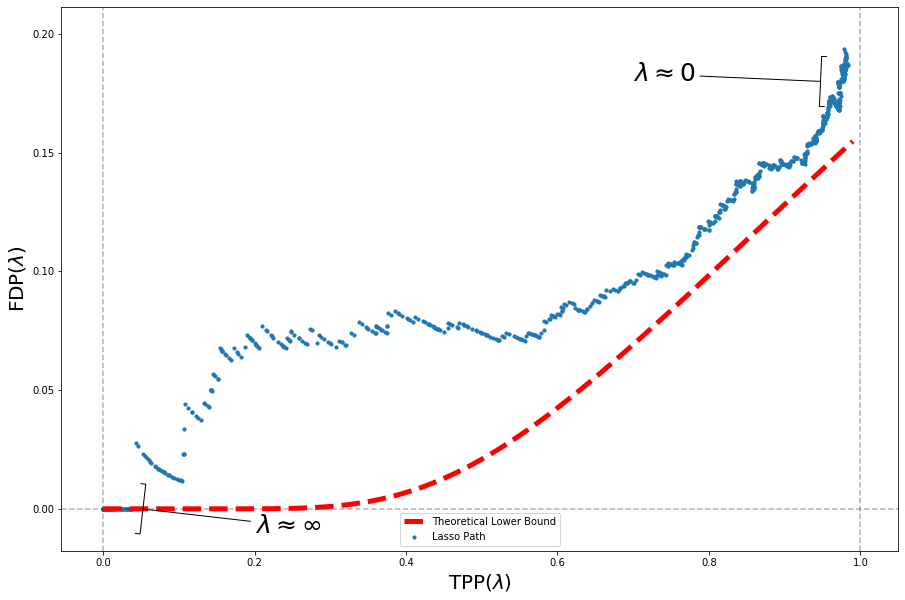

In [0]:
plt.scatter(tpp_path, fdp_path, s = 10, label = 'Lasso Path')
plt.xlabel('TPP($\lambda$)', size = 20)
plt.ylabel('FDP($\lambda$)', size = 20)
plt.axhline(y=0, color='k', linestyle = '--', alpha = 0.3)
plt.axvline(x=0, color='k', linestyle = '--', alpha = 0.3)
plt.axvline(x=1, color='k', linestyle = '--', alpha = 0.3)

plt.annotate(s = r"$\lambda \approx \infty$", xy = (0.05,0), xytext = (0.2, -0.01), arrowprops = {'arrowstyle':'-['}, size = 25)
plt.annotate(s = r"$\lambda \approx 0$", xy = (0.95, 0.18), xytext = (0.7,0.18), arrowprops = {'arrowstyle':'-['}, size = 25)

tpp_path = np.array(tpp_path)
index = np.where(tpp_path >= 0.5)[0][0]

fdp_path = np.array(fdp_path)
index = np.where(fdp_path > 0)[0][0]

plt.plot(x, y,'--', label = 'Theoretical Lower Bound', color = 'red', linewidth = 5)

plt.legend()
fig = plt.gcf()
fig.set_size_inches(15, 10)

## Figure 3 of our report

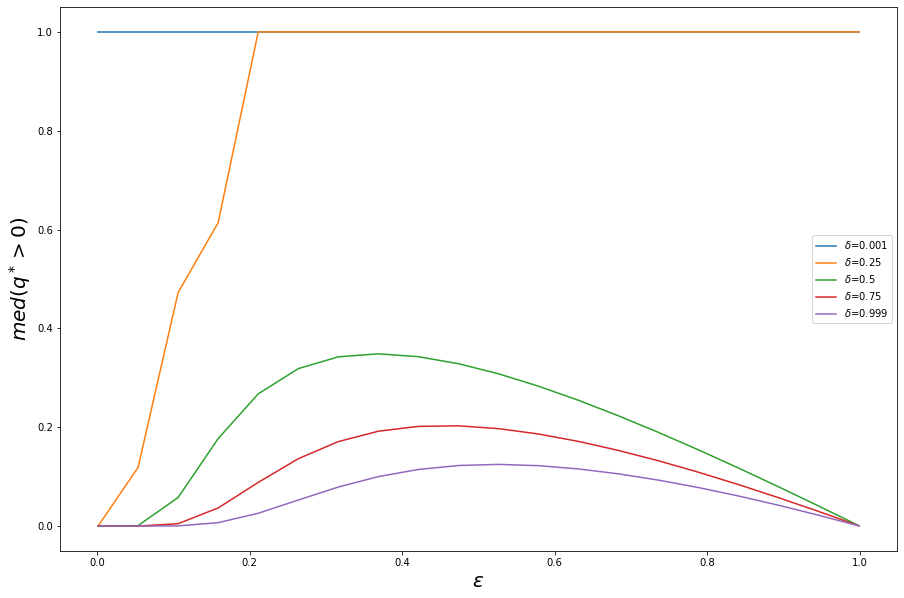

In [0]:
delta = 1
median_q_list = []
median_q = []

# Compute the median of q* when q* is positive for different values of epsilon
for j, delta in enumerate(np.linspace(0.001, 0.999, 5)):
    median_q = []
    for i,epsi in enumerate(np.linspace(0.001, 0.999, 20)):
        x,y = fdrlasso_py(delta,epsi)
        y[y == None] = 1.
        if len(y[y>0]) > 0:
            median_q.append(np.median(y[y>0]))
        else:
            median_q.append(0)
    median_q_list.append(median_q.copy())

# Plot these medians
for i,median_q in enumerate(median_q_list):
    plt.plot(np.linspace(0.001, 0.999, 20), median_q, label = r'$\delta$=' + str(np.round(np.linspace(0.001, 0.999, 5)[i], 3)))

plt.legend()
plt.xlabel(r'$\epsilon$', size = 20)
plt.ylabel(r'$med(q^* > 0)$', size = 20)
fig = plt.gcf()
fig.set_size_inches((15,10))

plt.xlabel(r'$\epsilon', size = 20)
plt.ylabel(r'$med(q^*$)', size = 20)
fig = plt.gcf()
fig.set_size_inches((15,10))

## Almost sure event numerical check

In [14]:
p_sample = np.array([800,1000,1500,1800,2000,2300,2500,2800,3000,3200,3500])

def fdrlasso_star(x, y, tpp_path):
    """
    Approximates q* for all values in tpp_path by interpolating linearly between points (x_i, y_i).
    """
    res = []
    for v in tpp_path :
        if v < x[0]:
            res.append(0)
        elif v >= x[-1]:
            res.append(y.max())
        else:
            index1 = (np.where(x <= v)[0])[-1]
            index2 = (np.where(x > v)[0])[0]
            res.append((((v-x[index1])/(x[index2]-x[index1])) * (y[index2]-y[index1])) + y[index1])
    res = np.nan_to_num(np.array(res, dtype=np.float))
    return res

def almost_sure_check(epsilon_c = 0.2 , delta_c =1. , sigma_c = 0., pathsnb =  200, p_tab =p_sample ):
    """
    Computes the empirical probability of the event that the Lasso Path gets under the lower bound for many values of n.
    The objective is to find out how fast this probability converges to 1.
    """
    res = []
    x,y = fdrlasso_py(delta_c,epsilon_c)
    for p_i in p_tab :
        res_p = []
    for i in range(pathsnb):
        tpp_path, fdp_path = TPP_FDP_path(p = p_i, n = None, delta = delta_c, epsilon = epsilon_c, sigma = sigma_c, signal_intensity = 4, n_alphas = 10, alpha_min = -3, alpha_max = 2)
        res_p.append(max(np.array(fdp_path) < fdrlasso_star(x, y, tpp_path)))
    res.append(np.mean(res_p))  
    return res





In [ ]:
# Simulation 1
evolution = almost_sure_check()

print(evolution)

In [ ]:
# Simulation 2
evolution = almost_sure_check()

print(evolution)

## Figure 4 of our report

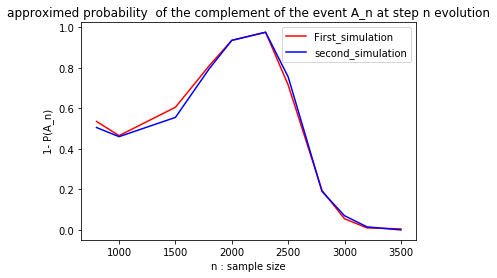

In [0]:
First_simulation= [0.535, 0.465, 0.605, 0.81, 0.935, 0.975, 0.715, 0.195, 0.055, 0.01, 0.005]
second_simulation = [0.505, 0.46, 0.555, 0.795, 0.935, 0.975, 0.755, 0.19, 0.07, 0.015, 0.0]
p_sample = np.array([800,1000,1500,1800,2000,2300,2500,2800,3000,3200,3500])
delta = 1.

n_sample = p_sample * delta

plt.plot(n_sample,First_simulation,color='r', label='First_simulation')
plt.plot(n_sample,second_simulation,color='b',label = 'second_simulation')
plt.legend()
plt.xlabel("n : sample size")
plt.ylabel("1- P(A_n)")
plt.show()

## The case of dependent features

In [0]:
def dependant_TPP_FDP_path(p = 1000, n = None, delta = 0.3, epsilon = 0.2, sigma = 1, signal_intensity = 4, n_alphas = 1000, alpha_min = -5, alpha_max = 2, theta = 2):
    """
    Simulates a dataset with interdependent columns and returns the FDP and TPP for each alpha in the Lasso path.
    
    p : Number of features.
    
    n : Number of observations.
    
    delta : ratio of observations n over number of features p (delta = n/p). Used if n is not given and ignored otherwise.
    
    epsilon: ratio of non-null features.
    
    sigma: standard deviation of the observation noise.
    
    signal_intensity: value of non-null feature coefficients.
    
    n_alphas = number of alphas to be tested in the Lasso path.   
    
    alpha_min, alpha_max : range of values alpha should take in log scale.
    
    theta  : number of copies of X^' 

    Returns TPP path and FDP path.

    
    """
    # number of observations
    if n is None:
        n = int(p * delta)
    
    # simulate dataset X_kappa
    X_kappa = np.random.randn(n, p // theta) / np.sqrt(n)
    
    # concatenate X_kappa to itself theta times
    X = np.repeat(X_kappa, theta, axis=1)
    
    # define true coefficients
    nonnull_coefs = int(epsilon * p)
    beta = np.hstack([np.zeros(p - nonnull_coefs), signal_intensity * np.ones(nonnull_coefs)])
    
    # simulate noise
    z = np.random.rand(n) * sigma
    
    # compute target variable
    Y = X.dot(beta) + z
    
    # compute Lasso path
    alphas, active, coef_path_lars = lasso_path(X, Y, alphas = np.logspace(alpha_min, alpha_max, n_alphas))
    
    # evaluate TPP and FDP for each alpha
    tpp_path = []
    fdp_path = []
    for coefs in active.T:
        tpp_path.append(TPP(beta, coefs))
        fdp_path.append(FDP(beta, coefs))
        
    return tpp_path, fdp_path

In [0]:
p_sample = np.array([2500,3000,3500,4000,4500])

def prob_of_A_n_c_ev(epsilon_c = 0.2 , delta_c =1. , sigma_c = 0., pathsnb =  200, p_tab =p_sample , theta_c = 2):
    """
    Computes the empirical probability of the event that the Lasso Path gets under the lower bound for all values in p_tab.
    """
    res = []
    x,y = fdrlasso_py(delta_c * theta_c ,epsilon_c)
    for p_i in p_tab :
        res_p = []
        for i in range(pathsnb):
            tpp_path, fdp_path = dependant_TPP_FDP_path(p = p_i, n = None, delta = delta_c, epsilon = epsilon_c, sigma = sigma_c, signal_intensity = 4, n_alphas = 10, alpha_min = -3, alpha_max = 2,theta =theta_c)
            res_p.append(max(np.array(fdp_path) < fdrlasso_star(y, x, tpp_path)))
        res.append(np.mean(res_p))  
    return res





## Figure 5 of our report

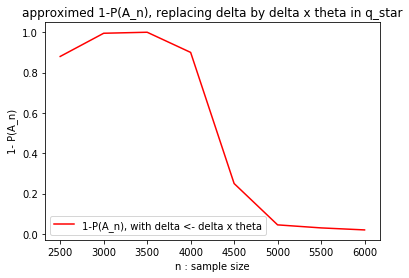

In [0]:
p_sample = np.array([2500,3000,3500,4000,4500,5000,5500,6000])
proba_array = np.array([0.88, 0.995, 1.0, 0.9, 0.25,0.045, 0.03, 0.02])
delta = 1.

n_sample = p_sample * delta

plt.plot(n_sample,proba_array,color='r', label='1-P(A_n), with delta <- delta x theta')

plt.legend()
plt.xlabel("n : sample size")
plt.title("approximed 1-P(A_n), replacing delta by delta x theta in q_star")
plt.ylabel("1- P(A_n)")
plt.show()

## Figure 6 of our report

In [ ]:
def visualise_tendance_with_dependance(epsilon_v = 0.2 ,delta_v = 1. , sigma_v = 1., pathsnb = 20 , p_v = 5000, theta_v=2):
    """
        Simulates many Lasso paths for different simulated data that has dependent features and plots them together along
        with q*(., ., delta*theta) and q*(., ., delta)
    """
    
    for i in range(pathsnb):
        tpp_path, fdp_path = dependant_TPP_FDP_path(p = p_v, n = None, delta = delta_v, epsilon = epsilon_v, sigma = sigma_v, signal_intensity = 4, n_alphas = 50, alpha_min = -3, alpha_max = 1, theta = theta_v)
        plt.plot(tpp_path, fdp_path , color = 'b')

    x , y = fdrlasso_py(delta = delta_v * theta_v, epsi = epsilon_v, x_min = 1e-4, x_max = 0.8)
    plt.plot(x, y,'--', label = ' q_star, delta <- delta x theta', color = "r")

    x1 , y2 = fdrlasso_py(delta = delta_v , epsi = epsilon_v, x_min = 1e-4, x_max = 0.8)
    plt.plot(x1, y2,'--', label = ' q_star, delta unchanged', color = "g")

    plt.legend(loc = 0)
    plt.xlabel('TPP')
    plt.ylabel('FDP')
    plt.title('asymtotic paths tendance')
    fig = plt.gcf()
    fig.set_size_inches(15, 10)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


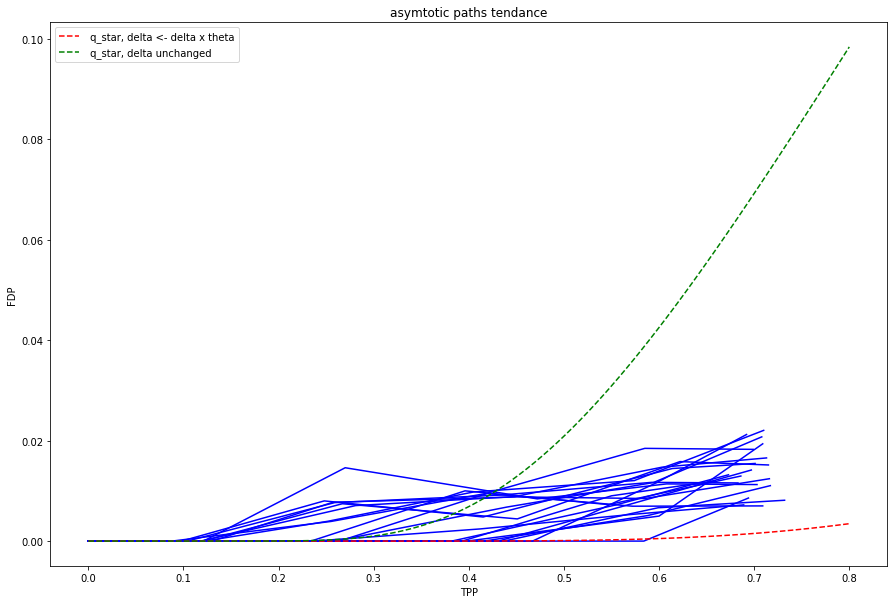

In [0]:
visualise_tendance_with_dependance()